In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import pickle
import seaborn as sns
import json

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

from matplotlib.lines import Line2D

In [2]:
feats = pd.read_csv("../System/feats_train.csv")

feats.set_index('index', inplace=True)

af = feats.loc[feats['class'] == 1]
naf = feats.loc[feats['class'] == 0]

labels = feats["class"]
feats.drop('class', axis=1, inplace=True)

feats.head()

,superlatives,degree_adverbs,comparative_adverbs,proper_nouns,dates,numbers,fp_pronouns,negations,pos_emotion,neg_emotion,...,readability,ap_num,ap_date,ap_title,alliteration,profanity,lexical_diversity,lexical_density,function_words,spelling_errors
index,,,,,,,,,,,,,,,,,,,,,
1,0.002488,0.007463,0.004975,0.069652,0.000000,0.012438,0.007463,0.000000,0.009950,0.014925,...,0.606467,1.0,0.0,0.0,0.000000,0.000000,0.613692,0.589242,0.410758,0.029340
2,0.000000,0.002618,0.002618,0.052356,0.000000,0.000000,0.015707,0.010471,0.002618,0.005236,...,0.595667,1.0,0.0,0.0,0.166667,0.002577,0.590206,0.597938,0.402062,0.064433
3,0.004255,0.004255,0.000000,0.042553,0.017021,0.008511,0.004255,0.017021,0.017021,0.004255,...,0.593667,1.0,0.0,0.0,0.000000,0.000000,0.566667,0.575000,0.425000,0.016667
4,0.000000,0.005291,0.000000,0.084656,0.000000,0.037037,0.000000,0.005291,0.015873,0.000000,...,0.517600,0.0,0.0,1.0,0.666667,0.000000,0.708333,0.604167,0.395833,0.156250
5,0.002066,0.000000,0.000000,0.049587,0.004132,0.035124,0.010331,0.002066,0.004132,0.006198,...,0.697400,0.0,0.0,0.0,0.000000,0.000000,0.529532,0.610998,0.389002,0.042770


In [3]:
fakes = pd.read_csv("../System/fake_news_feats_train.csv")
fakes.set_index('index', inplace=True)
fake_labels = fakes["class"]
fakes.drop('class', axis=1, inplace=True)

In [4]:
bop = pd.read_csv("../System/bop_train.csv")
bop.set_index('index', inplace=True)
bop.drop('class', axis=1, inplace=True)

fake_bop = pd.read_csv("../System/fake_news_bop_train.csv")
fake_bop.set_index('index', inplace=True)
fake_bop.drop('class', axis=1, inplace=True)

In [5]:
groups = ["complexity", "deception", "details", "formality"
                  ,"humour", "imagination", "vagueness"]

colour_map = {"complexity":"#396AB1", "deception":"#DA7C30", "details":"#3E9651", "formality":"#CC2529"
                  ,"humour":"#535154", "imagination":"#6B4C9A", "vagueness":"#922428"}

feat_group_map = dict()

for g in groups:
    with open("../System/feature_sets/{}.txt".format(g)) as file:
        for line in file:
            if line.strip() in feats.columns:
                feat_group_map[line.strip()] = g

In [6]:
classifier = LogisticRegression()
fake_news_classifier = LogisticRegression()
bop_classifier = LogisticRegression()
bop_fake_classifier = LogisticRegression()

pipeline = Pipeline([
        ('normalizer', StandardScaler()),  # Step1 - normalize data
#         ('normalizer', RobustScaler(quantile_range=(25, 75))),  # Step1 - normalize data
        ('clf', classifier)  # Step2 - classifier
        ])

fake_news_pipeline = Pipeline([
        ('normalizer', StandardScaler()),  # Step1 - normalize data
#         ('normalizer', RobustScaler(quantile_range=(25, 75))),  # Step1 - normalize data
        ('clf', fake_news_classifier)  # Step2 - classifier
        ])

bop_pipeline = Pipeline([
        ('normalizer', StandardScaler()),  # Step1 - normalize data
#         ('normalizer', RobustScaler(quantile_range=(25, 75))),  # Step1 - normalize data
        ('clf', bop_classifier)  # Step2 - classifier
        ])

bop_fake_pipeline = Pipeline([
        ('normalizer', StandardScaler()),  # Step1 - normalize data
#         ('normalizer', RobustScaler(quantile_range=(25, 75))),  # Step1 - normalize data
        ('clf', bop_fake_classifier)  # Step2 - classifier
        ])

pipeline.fit(feats, labels)
fake_news_pipeline.fit(fakes, fake_labels)
bop_pipeline.fit(bop, labels)
bop_fake_pipeline.fit(fake_bop, fake_labels)

Pipeline(memory=None,
     steps=[('normalizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [7]:
def get_weights(CLF, feats):
    svc_coeffs = CLF.coef_.ravel()

    rank_pd = pd.DataFrame()
    rank_pd['Weights'] = svc_coeffs
    rank_pd['Features'] = feats.columns.values
    rank_pd.set_index("Features", inplace=True)
#     rank_pd.Weights = rank_pd.Weights * feats[rank_pd.index].std()
    sorted_ranks = rank_pd.sort_values(by='Weights', ascending=False)
    return sorted_ranks
    
sorted_ranks = get_weights(classifier, feats)
sorted_fake_ranks = get_weights(fake_news_classifier, fakes)
sorted_bop = get_weights(bop_classifier, bop)
sorted_fake_bop = get_weights(bop_fake_classifier, fake_bop)

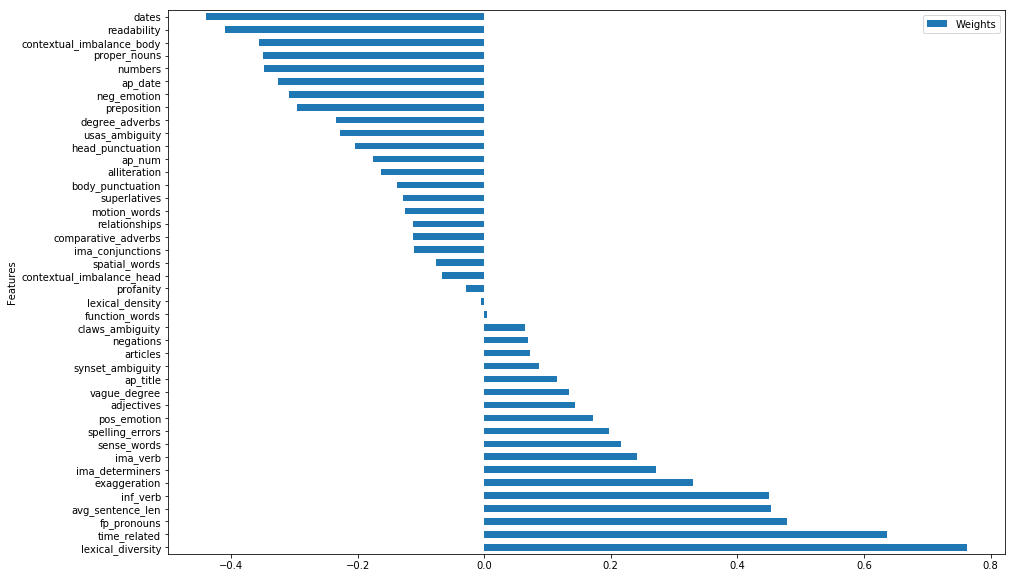

In [8]:
sorted_ranks.plot(kind='barh', figsize=(15,10))
sorted_ranks['group'] = [feat_group_map[feat] for feat in sorted_ranks.index.values]
plt.show()

In [9]:
# Sort the data by absolute value of svm weight
sorted_data = sorted_ranks.assign(f=abs(sorted_ranks['Weights']))\
    .sort_values(by='f', ascending=False)\
    .drop('f', axis=1)
sorted_data = sorted_data.round(3)
sorted_data.head(10)

,Weights,group
Features,,
lexical_diversity,0.763,complexity
time_related,0.637,details
fp_pronouns,0.478,deception
avg_sentence_len,0.454,complexity
inf_verb,0.451,imagination
dates,-0.439,details
readability,-0.410,complexity
contextual_imbalance_body,-0.356,humour
proper_nouns,-0.349,details


,Weights,group
Features,,
lexical_diversity,1.370,complexity
proper_nouns,1.288,details
body_punctuation,-1.146,complexity
readability,-1.023,complexity
dates,-0.616,details
inf_verb,0.587,imagination
fp_pronouns,0.584,deception
profanity,0.529,humour
spelling_errors,0.494,formality


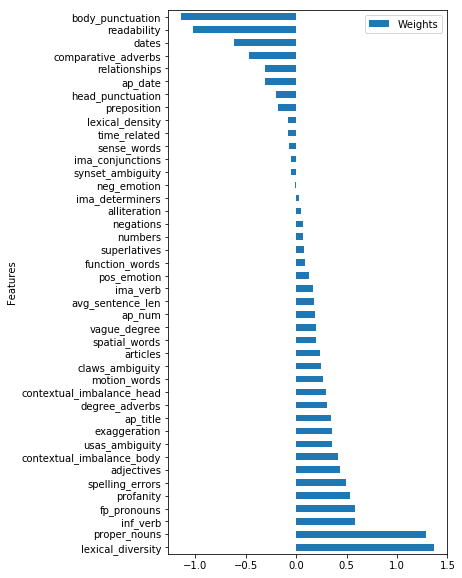

In [10]:
sorted_fake_ranks.plot(kind='barh', figsize=(5,10))

# Print fake news top ten
sorted_fakes = sorted_fake_ranks.assign(f=abs(sorted_fake_ranks['Weights']))\
    .sort_values(by='f', ascending=False)\
    .drop('f', axis=1)
sorted_fakes = sorted_fakes.round(3)
sorted_fakes['group'] = [feat_group_map[feat] for feat in sorted_fakes.index.values]
sorted_fakes.head(10)

In [11]:
print(sorted_data.head(10).to_latex())

\begin{tabular}{lrl}
\toprule
{} &  Weights &        group \\
Features                  &          &              \\
\midrule
lexical\_diversity         &    0.763 &   complexity \\
time\_related              &    0.637 &      details \\
fp\_pronouns               &    0.478 &    deception \\
avg\_sentence\_len          &    0.454 &   complexity \\
inf\_verb                  &    0.451 &  imagination \\
dates                     &   -0.439 &      details \\
readability               &   -0.410 &   complexity \\
contextual\_imbalance\_body &   -0.356 &       humour \\
proper\_nouns              &   -0.349 &      details \\
numbers                   &   -0.348 &      details \\
\bottomrule
\end{tabular}



In [12]:
print(sorted_fakes.head(10).to_latex())

\begin{tabular}{lrl}
\toprule
{} &  Weights &        group \\
Features            &          &              \\
\midrule
lexical\_diversity   &    1.370 &   complexity \\
proper\_nouns        &    1.288 &      details \\
body\_punctuation    &   -1.146 &   complexity \\
readability         &   -1.023 &   complexity \\
dates               &   -0.616 &      details \\
inf\_verb            &    0.587 &  imagination \\
fp\_pronouns         &    0.584 &    deception \\
profanity           &    0.529 &       humour \\
spelling\_errors     &    0.494 &    formality \\
comparative\_adverbs &   -0.467 &    vagueness \\
\bottomrule
\end{tabular}



In [13]:
sorted_data.head()

,Weights,group
Features,,
lexical_diversity,0.763,complexity
time_related,0.637,details
fp_pronouns,0.478,deception
avg_sentence_len,0.454,complexity
inf_verb,0.451,imagination


In [14]:
colour_map.keys()

dict_keys(['complexity', 'deception', 'details', 'formality', 'humour', 'imagination', 'vagueness'])

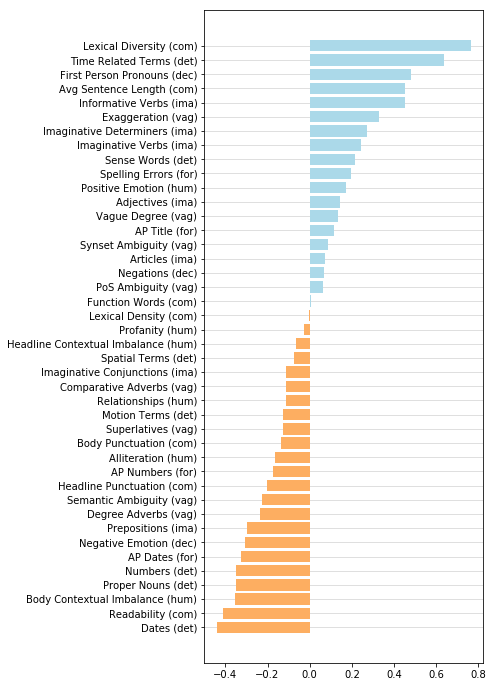

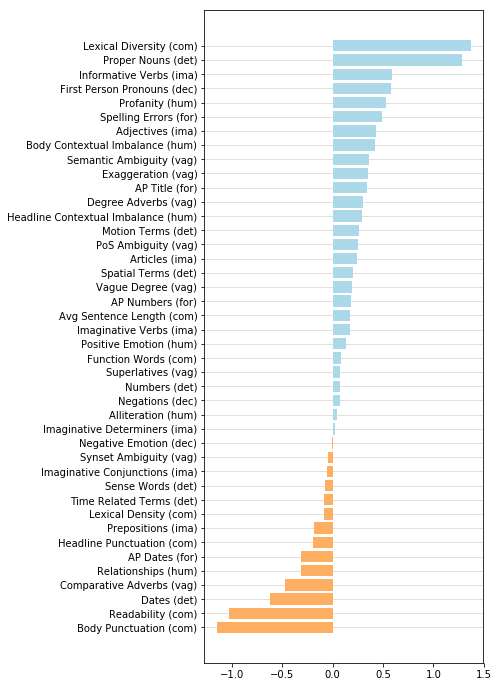

In [15]:
def plot_weights(weight_pd, name):
    fig, ax = plt.subplots(figsize=(5, 12))

    y_pos = np.arange(len(weight_pd.index))[::-1]

#     colour_lambda = lambda x: "#998ec3" if x>0 else '#f1a340'
    colour_lambda = lambda x: "#abd9e9" if x>0 else '#fdae61'

    name_map = json.load(open("name_map.json"))
    feat_names = [name_map[x] for x in weight_pd.index]
    grouped_names = []
    
    for fancy_name, rubbish_name in zip(feat_names, weight_pd.index):
        new_name = "{} ({})".format(fancy_name, feat_group_map[rubbish_name][:3])
        grouped_names.append(new_name)
    
    feat_colours = [colour_map[feat_group_map[x]] for x in weight_pd.index]
    
#     leg_lines = [Line2D([0], [0], color='#d7191c', lw=4),
#                 Line2D([0], [0], color='#2c7bb6', lw=4)]
#     leg_lines = [Line2D([0], [0], color=c, lw=4) for c in colour_map.values()] 

    bars = ax.barh(y_pos, weight_pd.Weights, color=weight_pd.Weights.apply(colour_lambda), zorder=3)
#     bars = ax.barh(y_pos, weight_pd.Weights, color=feat_colours)
#     bars = ax.barh(y_pos, weight_pd.Weights, color="#abd9e9", zorder=3)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(grouped_names)
                       
#     ax.legend(leg_lines, ['Details', 'Complexity'], loc=4, prop={'size': 10})
#     ax.legend(leg_lines, list(colour_map.keys()), loc=4, prop={'size': 10})

    ax.grid(b=True, axis='y', zorder=0, alpha=0.5)

#     for bar, feat in zip(bars, weight_pd.index):
#         if feat_group_map[feat] == "details":
#             bar.set_color("#d7191c")
#         elif feat_group_map[feat] == "complexity":
#             bar.set_color("#2c7bb6")

    plt.show()
    fig.savefig("graphs/{}.pdf".format(name), bbox_inches='tight')
    
plot_weights(sorted_ranks, "af_weights")
plot_weights(sorted_fake_ranks, "fake_weights")

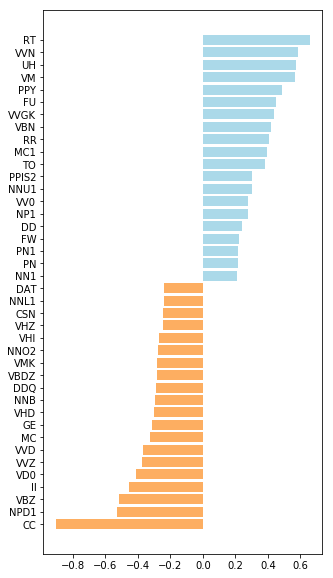

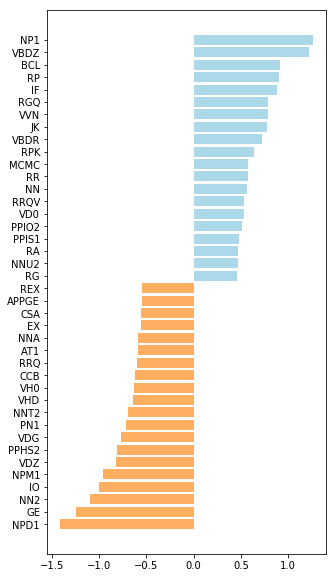

In [16]:
reduced_bop = sorted_bop.iloc[np.r_[0:20, -20:0]]
reduced_fake_bop = sorted_fake_bop.iloc[np.r_[0:20, -20:0]]

def plot_bop_weights(weight_pd):
    fig, ax = plt.subplots(figsize=(5, 10))

    y_pos = np.arange(len(weight_pd.index))[::-1]
    colour_lambda = lambda x: "#abd9e9" if x>0 else '#fdae61'

    bars = ax.barh(y_pos, weight_pd.Weights, color=weight_pd.Weights.apply(colour_lambda))
#     bars = ax.barh(y_pos, weight_pd.Weights, color=feat_colours)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(weight_pd.index)

    plt.show()

plot_bop_weights(reduced_bop)
plot_bop_weights(reduced_fake_bop)

In [17]:
# # create a json file that holds a map of feature to nicely formatted name
# feat_names = ["Lexical Diversity", "Time Related Terms", "Informative Verbs", "Avg Sentence Length",
#                  "First Person Pronouns", "Exaggeration", "Imaginative Determiners", "Imaginative Verbs",
#                  "Spelling Errors", "Sense Words", "Positive Emotion", "Adjectives", "Vague Degree", 
#                  "Synset Ambiguity", "AP Title", "Articles", "PoS Ambiguity", "Negations", "Function Words", 
#                  "Lexical Density", "Profanity", "Spatial Terms", "Headline Contextual Imbalance", 
#                  "Imaginative Conjunctions", "Comparative Adverbs", "Relationships", "Superlatives", "Motion Terms", 
#                  "Alliteration", "Body Punctuation", "AP Numbers", "Headline Punctuation", "Semantic Ambiguity",
#                  "Degree Adverbs", "Negative Emotion", "Prepositions", "Body Contextual Imbalance",
#                  "AP Dates", "Numbers", "Proper Nouns", "Readability", "Dates"]

# name_map = {x:y for x, y in zip(sorted_ranks.index, feat_names)}
# with open("name_map.json", 'w') as f:
#     json.dump(name_map, f)

In [18]:
y_pos[::-1]

NameError: name 'y_pos' is not defined

In [ ]:
sorted_data.loc[sorted_data['group']=='vagueness']

In [ ]:
temp = sorted_data.copy()
temp["Weights"] = temp["Weights"].abs()

lr_groups = temp.groupby('group').sum()
lr_groups['mean'] = temp.groupby('group').mean()
lr_groups['count'] = temp.groupby('group').count()

lr_groups

In [ ]:
def classify(tab, lab):
    classifier = LogisticRegression()

    pipeline = Pipeline([
            ('normalizer', StandardScaler()),  # Step1 - normalize data
    #         ('normalizer', RobustScaler(quantile_range=(25, 75))),  # Step1 - normalize data
            ('clf', classifier)  # Step2 - classifier
            ])

    predicted = cross_val_predict(pipeline, tab, lab, cv=10)

    score = metrics.f1_score(lab, predicted, pos_label=1)
    precision = metrics.precision_score(lab, predicted)
    recall = metrics.recall_score(lab, predicted)
    accuracy = metrics.accuracy_score(lab, predicted)

    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("Accuracy: {}".format(accuracy))
    print("F1-Score: {}".format(score))

In [ ]:
sca_feats = StandardScaler().fit_transform(feats)
logreg = LogisticRegression()
# classifier.fit(sca_feats, labels)
# pred = classifier.predict(sca_feats)
# probs = classifier.predict_proba(sca_feats)

pred = cross_val_predict(logreg, sca_feats, labels, cv=10)
probs = cross_val_predict(logreg, sca_feats, labels, cv=10, method='predict_proba')

In [ ]:
classify(feats, labels)

In [ ]:
sca_feats[:, 0].std()

In [ ]:
sca_feats.std(axis=0)

In [ ]:
column_names = ["Index", "URL", "Headline", "Year", "Category", "April Fool", "Set"]
meta = pd.read_csv("../Corpus Construction/meta.csv", delimiter=";", header=None, names=column_names)
meta.set_index('Index', inplace=True)

meta = meta.loc[:, ['Headline']]
meta["Truth"] = labels
meta["Prediction"] = pred
meta["Prob Est NAF"] = probs[:, 0]
meta["Prob Est AF"] = probs[:, 1]

errors = meta.loc[meta.Truth != meta.Prediction]
correct = meta.loc[meta.Truth == meta.Prediction]

In [ ]:
errors